In [2]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
# Load the saved model and tokenizer
#loadstr = '/home/ubuntu/bstadt-tlm/tlm/now-tlm-2025-08-15_15-08-29/checkpoint-112712/'
loadstr = '/home/ubuntu/bstadt-tlm/tlm/now-tlm-2025-08-15_15-08-29/checkpoint-60000/'
model = AutoModelForMaskedLM.from_pretrained(loadstr)
#tokenizer = BertTokenizerFast.from_pretrained('../coca_tokenized/tokenizer/')
tokenizer = AutoTokenizer.from_pretrained(loadstr)

In [3]:
import torch
import torch.nn.functional as F
def l_fills(phrase, fills, model, tokenizer, minyear=10, maxyear=26):
    model.eval()

    fill_target_ids = [tokenizer.encode(fill, add_special_tokens=False) for fill in fills]
    years = list(range(minyear, maxyear))
    months = list(range(1, 13))
    timetoks = []
    for year in years:
        for month in months:
            timetoks.append('[TIME:{i}-{j}]'.format(i=year, j=month))

    timetok_fill_probs = []
    for timetok in timetoks:
        temporal_phrase = timetok + phrase
        with torch.no_grad():
            input_ids = tokenizer.encode(temporal_phrase, add_special_tokens=False, return_tensors='pt')
            mask_locs = torch.where(input_ids==tokenizer.mask_token_id)

            outputs = model(input_ids=input_ids)
            fill_logits = outputs.logits[mask_locs]
            fill_sublogits = fill_logits[:, fill_target_ids][0]
            cur_fill_probs = F.softmax(fill_sublogits, dim=0)

            timetok_fill_probs.append(cur_fill_probs)

    return timetoks, timetok_fill_probs

/lambda/nfs/bstadt-tlm/tlm/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


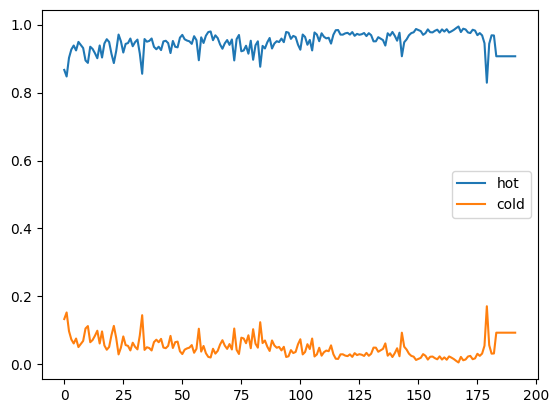

In [4]:
import numpy as np
from matplotlib import pyplot as plt
template = 'It\'s [MASK] outside today.'
timetoks, fill_probs = l_fills(template, ['hot', 'cold'], model, tokenizer)

x = np.arange(len(timetoks))
plt.figure()
plt.plot(x, [e[0] for e in fill_probs], label='hot')
plt.plot(x, [e[1] for e in fill_probs], label='cold')
plt.legend()
plt.show()

In [5]:
import torch
import torch.nn.functional as F
def l_time(phrase, model, tokenizer, minyear=10, maxyear=26):
    model.eval()

    years = list(range(minyear, maxyear))
    months = list(range(1, 13))
    timetoks = []
    for year in years:
        for month in months:
            timetoks.append('[TIME:{i}-{j}]'.format(i=year, j=month))
    fill_target_ids = [tokenizer.encode(e, add_special_tokens=False) for e in timetoks]

    temporal_phrase = '[MASK] '+ phrase
    with torch.no_grad():
        input_ids = tokenizer.encode(temporal_phrase, add_special_tokens=False, return_tensors='pt')
        mask_locs = torch.where(input_ids==tokenizer.mask_token_id)

        outputs = model(input_ids=input_ids)
        fill_logits = outputs.logits[mask_locs]
        fill_sublogits = fill_logits[:, fill_target_ids][0]
        time_fill_probs = F.softmax(fill_sublogits, dim=0)

    return timetoks, time_fill_probs

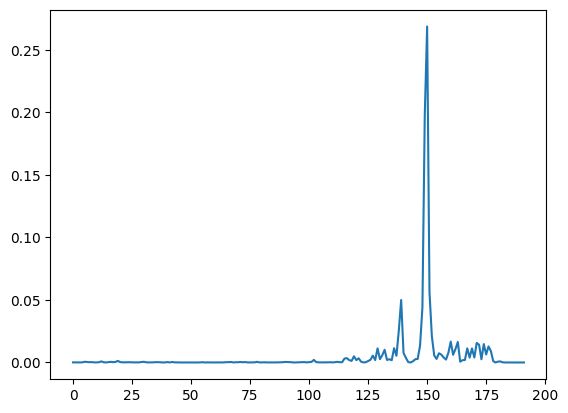

In [6]:
timetoks, probs = l_time('Merry Christmas', model, tokenizer)

xs = np.arange(len(timetoks))
plt.figure()
plt.plot(xs, probs)
plt.show()

In [7]:
from matplotlib import pyplot as plt
def ptime_given_slotfill(phrase, template, model, tokenizer, title, annotate=None, annotate_text=None, vlines=None, plot_template=False, plot_fill=False, return_only=False, minyear=None, maxyear=None):
    timetoks, fill_year_probs = l_time(phrase, model, tokenizer, minyear=minyear, maxyear=maxyear)
    _, template_year_probs = l_time(template, model, tokenizer, minyear=minyear, maxyear=maxyear)
    bayes_factors = fill_year_probs/template_year_probs

    if return_only:
        return timetoks, bayes_factors

    plt.figure()
    plt.title(title)
    plt.ylabel('Bayes Factor')
    plt.xlabel('Year')
    plt.plot([i for i in range(len(timetoks))], bayes_factors)
    plt.legend()

    if annotate != None:
        plt.axvspan(annotate[0], annotate[1], alpha=0.3, color='green')
        if annotate_text != None:
            plt.text(annotate[0], 0, annotate_text, ha='left', va='bottom')

    if vlines != None:
        for vline in vlines:
            plt.axvline(vline, color='red', linestyle='--')


    plt.show()

    if plot_fill:
        plt.plot(years, fill_year_probs, label='Fill')
        plt.legend()
        plt.show()

    if plot_template:
        plt.plot(years, template_year_probs, label='Template')
        plt.legend()
        plt.show()

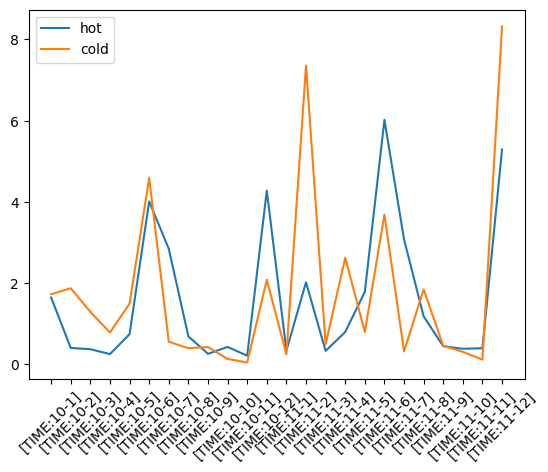

In [8]:
timetoks, hot_bayes = ptime_given_slotfill('It\'s hot outside today', 'It\'s [MASK_NOLOSS] outside today', model, tokenizer, title='', return_only=True, minyear=10, maxyear=12)
_, cold_bayes = ptime_given_slotfill('It\'s cold outside today', 'It\'s [MASK_NOLOSS] outside today', model, tokenizer, title='', return_only=True, minyear=10, maxyear=12)

plt.figure()
plt.plot(hot_bayes, label='hot')
plt.plot(cold_bayes, label='cold')
plt.xticks(range(len(timetoks)), timetoks, rotation=45)

plt.legend()
plt.show()

/lambda/nfs/bstadt-tlm/tlm/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


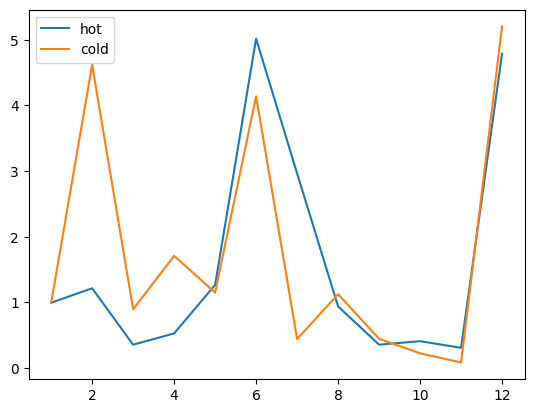

In [10]:
from collections import defaultdict

timetoks, hot_bayes = ptime_given_slotfill('It\'s hot outside today', 'It\'s [MASK_NOLOSS] outside today', model, tokenizer, title='', return_only=True, minyear=10, maxyear=12)
_, cold_bayes = ptime_given_slotfill('It\'s cold outside today', 'It\'s [MASK_NOLOSS] outside today', model, tokenizer, title='', return_only=True, minyear=10, maxyear=12)


hot_month_to_bayes = defaultdict(list)
cold_month_to_bayes = defaultdict(list)
for i, timetok in enumerate(timetoks):
    month = int(timetok.split('-')[1].replace(']', ''))
    hot_month_to_bayes[month].append(hot_bayes[i])
    cold_month_to_bayes[month].append(cold_bayes[i])

plt.figure()
plt.plot([i for i in range(1, 13)], [np.mean(hot_month_to_bayes[i]) for i in range(1, 13)], label='hot')
plt.plot([i for i in range(1, 13)], [np.mean(cold_month_to_bayes[i]) for i in range(1, 13)], label='cold')
plt.legend()
plt.show()


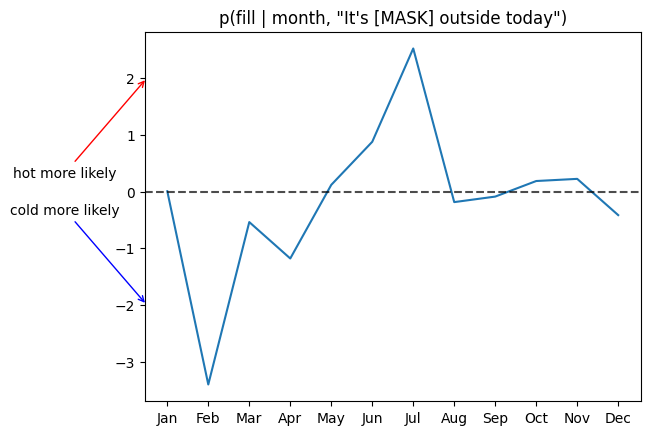

In [40]:
plt.figure()
plt.title('p(fill | month, \"It\'s [MASK] outside today")')
plt.plot([i for i in range(1, 13)], [np.mean(hot_month_to_bayes[i]) - np.mean(cold_month_to_bayes[i]) for i in range(1, 13)])
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)

# Add month labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), month_names)

# Add annotations with arrows
plt.annotate('hot more likely', xy=(0.5, 2), xytext=(-1.5, 0.2), 
             ha='center', va='bottom',
             arrowprops=dict(arrowstyle='->', color='red'))
plt.annotate('cold more likely', xy=(0.5, -2), xytext=(-1.5, -0.2), 
             ha='center', va='top',
             arrowprops=dict(arrowstyle='->', color='blue'))

plt.show()
